In [1]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

seed = 42
np.random.seed = seed
np.random.seed = seed

In [4]:
#Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]

test_ids = next(os.walk(TEST_PATH))[1]


In [5]:
#Create array with zeros of the same size as the resize image size.
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


<ipython-input-5-f9e3161f2de2>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


In [6]:
print('Resizing training images and masks....')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ +'.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range=True)
    X_train[n] = img #filling empty X-train with img data
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/'+ mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range=True), axis = -1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]<ipython-input-6-543aece4483b>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
 15%|████████████▍                                                                      | 3/20 [00:00<00:00, 20.32it/s]

Resizing training images and masks....


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.49it/s]


In [7]:
#test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []
print('Resizing test images....')

for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/'+ id_+ '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 28.79it/s]

Resizing test images....


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.49it/s]

Done!


In [8]:
'''
#Let's see if things look all right by drawing some random images and their associated masks
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
'''

"\n#Let's see if things look all right by drawing some random images and their associated masks\nix = random.randint(0, len(train_ids))\nimshow(X_train[ix])\nplt.show()\nimshow(Y_train[ix])\nplt.show()\n"

In [9]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

In [10]:
#contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.9)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [11]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_cyclone2.h5',verbose=1, save_best_only=True)

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs2'),
    checkpointer
]

In [13]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size = 2, epochs=30, callbacks = callbacks)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.6648
Epoch 00001: val_loss improved from inf to 0.48772, saving model to model_cyclone2.h5
9/9 [==============================] - 7s 401ms/step - loss: 0.6391 - accuracy: 0.6648 - val_loss: 0.4877 - val_accuracy: 0.8383
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8067
Epoch 00002: val_loss improved from 0.48772 to 0.46131, saving model to model_cyclone2.h5
9/9 [==============================] - 3s 317ms/step - loss: 0.4732 - accuracy: 0.8067 - val_loss: 0.4613 - val_accuracy: 0.8383
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8615
Epoch 00003: val_loss did not improve from 0.46131
9/9 [==============================] - 3s 284ms/step - loss: 0.3574 - accuracy: 0.8615 - val_loss: 0.5006 - val_accuracy: 0.8383
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8783
Epoch 00004: val_l

In [14]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 162ms/step


In [22]:
preds_train_t = (preds_train >0.2).astype(np.uint8)
preds_val_t = (preds_val >0.7).astype(np.uint8)
preds_test_t = (preds_test >0.7).astype(np.uint8)

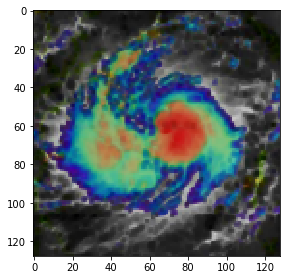

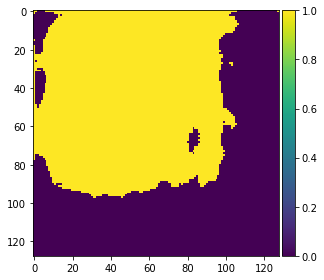

In [23]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
#imshow(np.squeeze(Y_train[ix]))
#plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [17]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
#imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
#plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
#!tensorboard --logdir=logs/ --host localhost --port 8080